# DBSCAN and HDBSCAN clustering of NGC 2506

We start with querying Gaia data around the open clusters NGC 2506.

In [1]:
%%time
from astroquery.gaia import Gaia

Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1 #default is 50 rows max, -1 for unlimited

RA = 120.0
DEC = -10.76
RADIUS = 0.4

queryStringGaia = """select * from gaiadr3.gaia_source
                    where 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',%.3f,%.3f,%.3f))
                    and phot_g_mean_mag<18 and pmra is not null""" % (RA,DEC,RADIUS)

job = Gaia.launch_job_async(queryStringGaia,
                    dump_to_file=False, output_format='votable')
GaiaT = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]
CPU times: user 3.36 s, sys: 190 ms, total: 3.55 s
Wall time: 12.6 s


Text(0, 0.5, 'G')

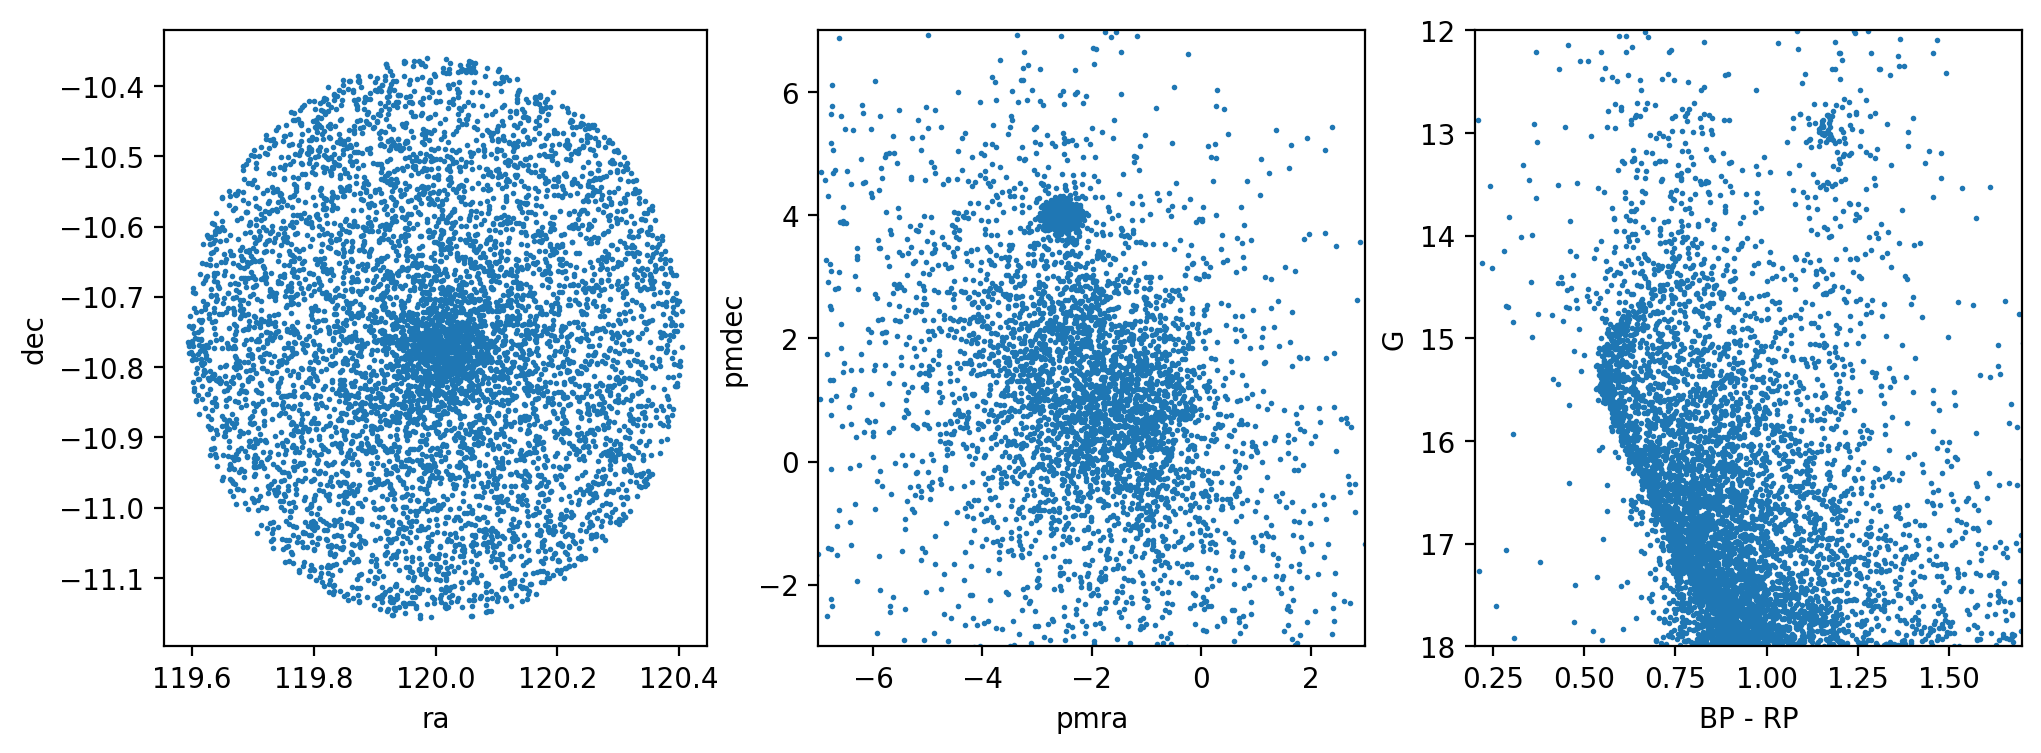

In [2]:
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import numpy as np

plt.figure( figsize=(12,4) )

plt.subplot(131,aspect= abs(1./np.sin(np.radians(RA))) )
plt.scatter( GaiaT['ra'] , GaiaT['dec'] , s=1 )
plt.xlabel('ra'); plt.ylabel('dec')

plt.subplot(132)
plt.scatter( GaiaT['pmra'] , GaiaT['pmdec'] , s=1 )
plt.xlim(-7,3); plt.ylim(-3,7)
plt.xlabel('pmra'); plt.ylabel('pmdec')

plt.subplot(133)
plt.scatter( GaiaT['bp_rp'] , GaiaT['phot_g_mean_mag'] , s=1 )
plt.xlim(0.2,1.7); plt.ylim(18,12)
plt.xlabel('BP - RP'); plt.ylabel('G')

# DBSCAN

We vary the two hyperparameters `eps` (the maximum distance between two points for one to be considered as in the neighborhood of the other) and `min_samples` (the number of points in the neighbourhood of a point, including itself, for it to be considered a core point).

eps=0.30    min_samples=10
Estimated number of clusters: 8
Estimated number of noise points: 1487

eps=0.30    min_samples=100
Estimated number of clusters: 3
Estimated number of noise points: 4586

eps=0.10    min_samples=10
Estimated number of clusters: 32
Estimated number of noise points: 3937



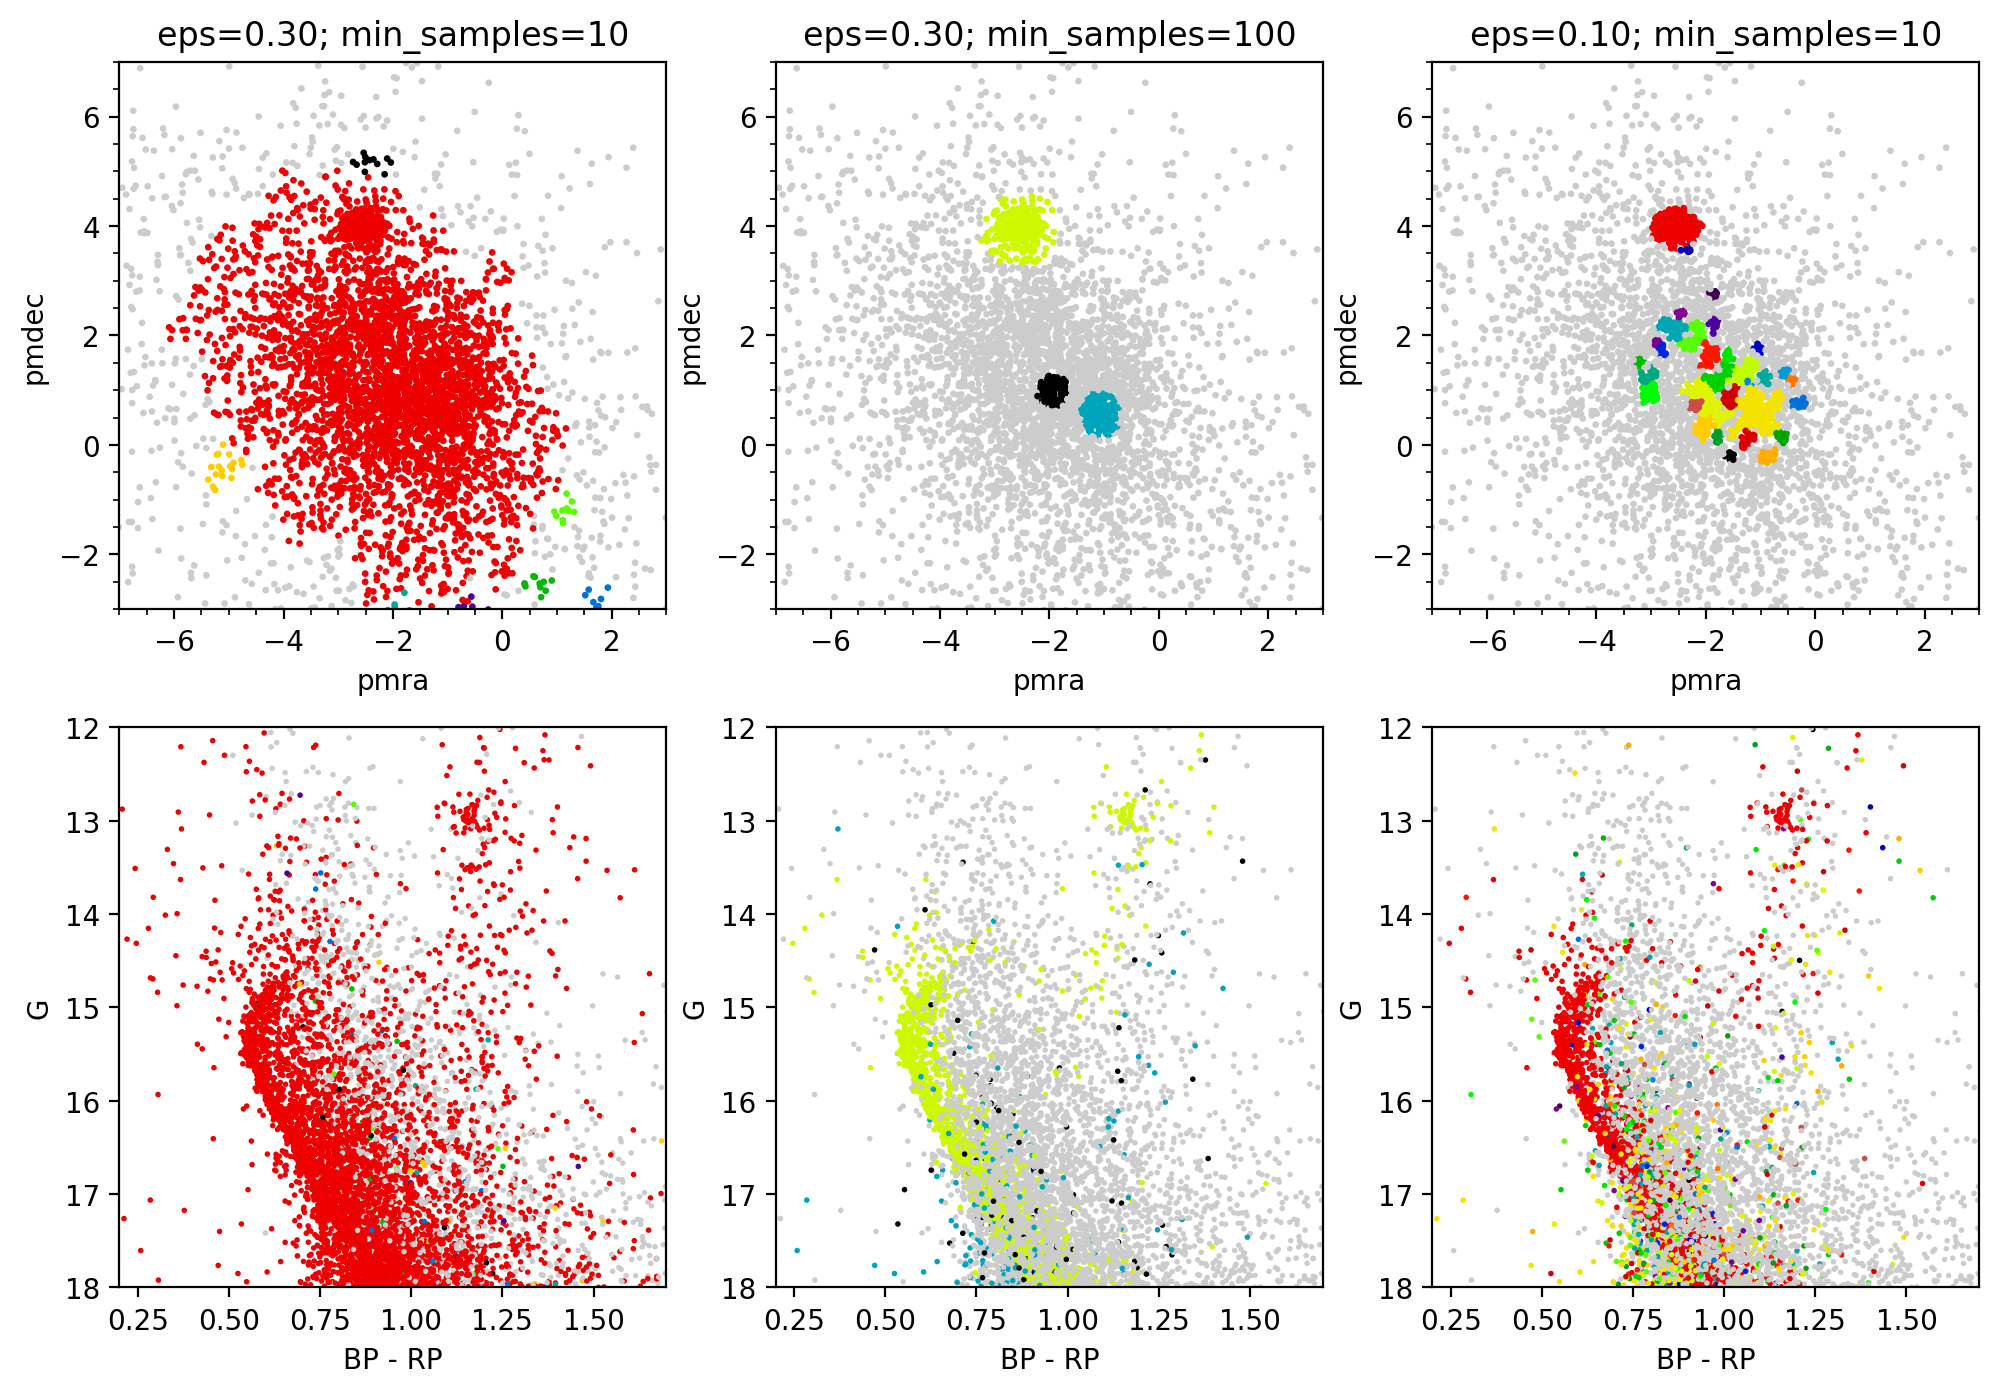

In [3]:
from sklearn.cluster import DBSCAN

X = np.array([GaiaT['pmra'] , GaiaT['pmdec']]).T

plt.figure(figsize=(12,8))
iii = 1

for eps,min_samples in [(0.3,10),(0.3,100),(0.1,10)]:

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    n_noise_ = list(db.labels_).count(-1)

    print('eps=%.2f    min_samples=%i' % (eps,min_samples))
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print('')

    # Plot the cluster labels in proper motion space:

    plt.subplot(2,3,iii,aspect=1)
    plt.title('eps=%.2f; min_samples=%i' % (eps,min_samples))
    plt.minorticks_on()
    plt.scatter( GaiaT['pmra'] , GaiaT['pmdec'] , s=2 , c=db.labels_ , cmap='nipy_spectral_r')
    plt.xlim(-7,3); plt.ylim(-3,7)
    plt.xlabel('pmra'); plt.ylabel('pmdec')

    plt.subplot(2,3,iii+3)
    plt.scatter( GaiaT['bp_rp'] , GaiaT['phot_g_mean_mag'] , s=1 , c=db.labels_ , cmap='nipy_spectral_r' )
    plt.xlim(0.2,1.7); plt.ylim(18,12)
    plt.xlabel('BP - RP'); plt.ylabel('G')
    
    iii += 1

# Scipy to visualise hierarchy in the data

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

In [4]:
import scipy.cluster.hierarchy as sch
pairwise_distances = sch.distance.pdist(X)
Z = sch.linkage(pairwise_distances)

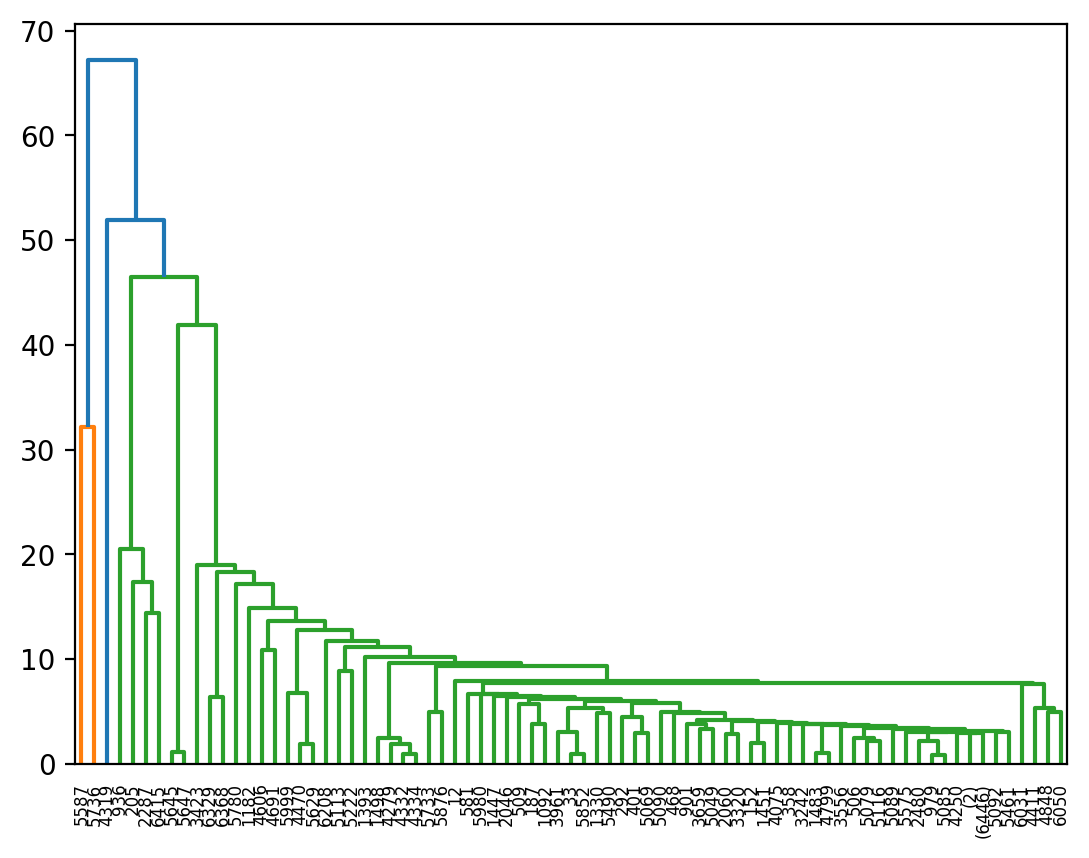

In [5]:
P = sch.dendrogram(Z,p=40,truncate_mode='level')

# HDBSCAN

https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html

HDBSCAN only has one hyperparameter `min_cluster_size`, which is the minimum number in a group for it to be considered a cluster.

In [6]:
from sklearn.cluster import HDBSCAN

Estimated number of clusters: 865
Estimated number of noise points: 1699

Estimated number of clusters: 22
Estimated number of noise points: 3086

Estimated number of clusters: 2
Estimated number of noise points: 3186



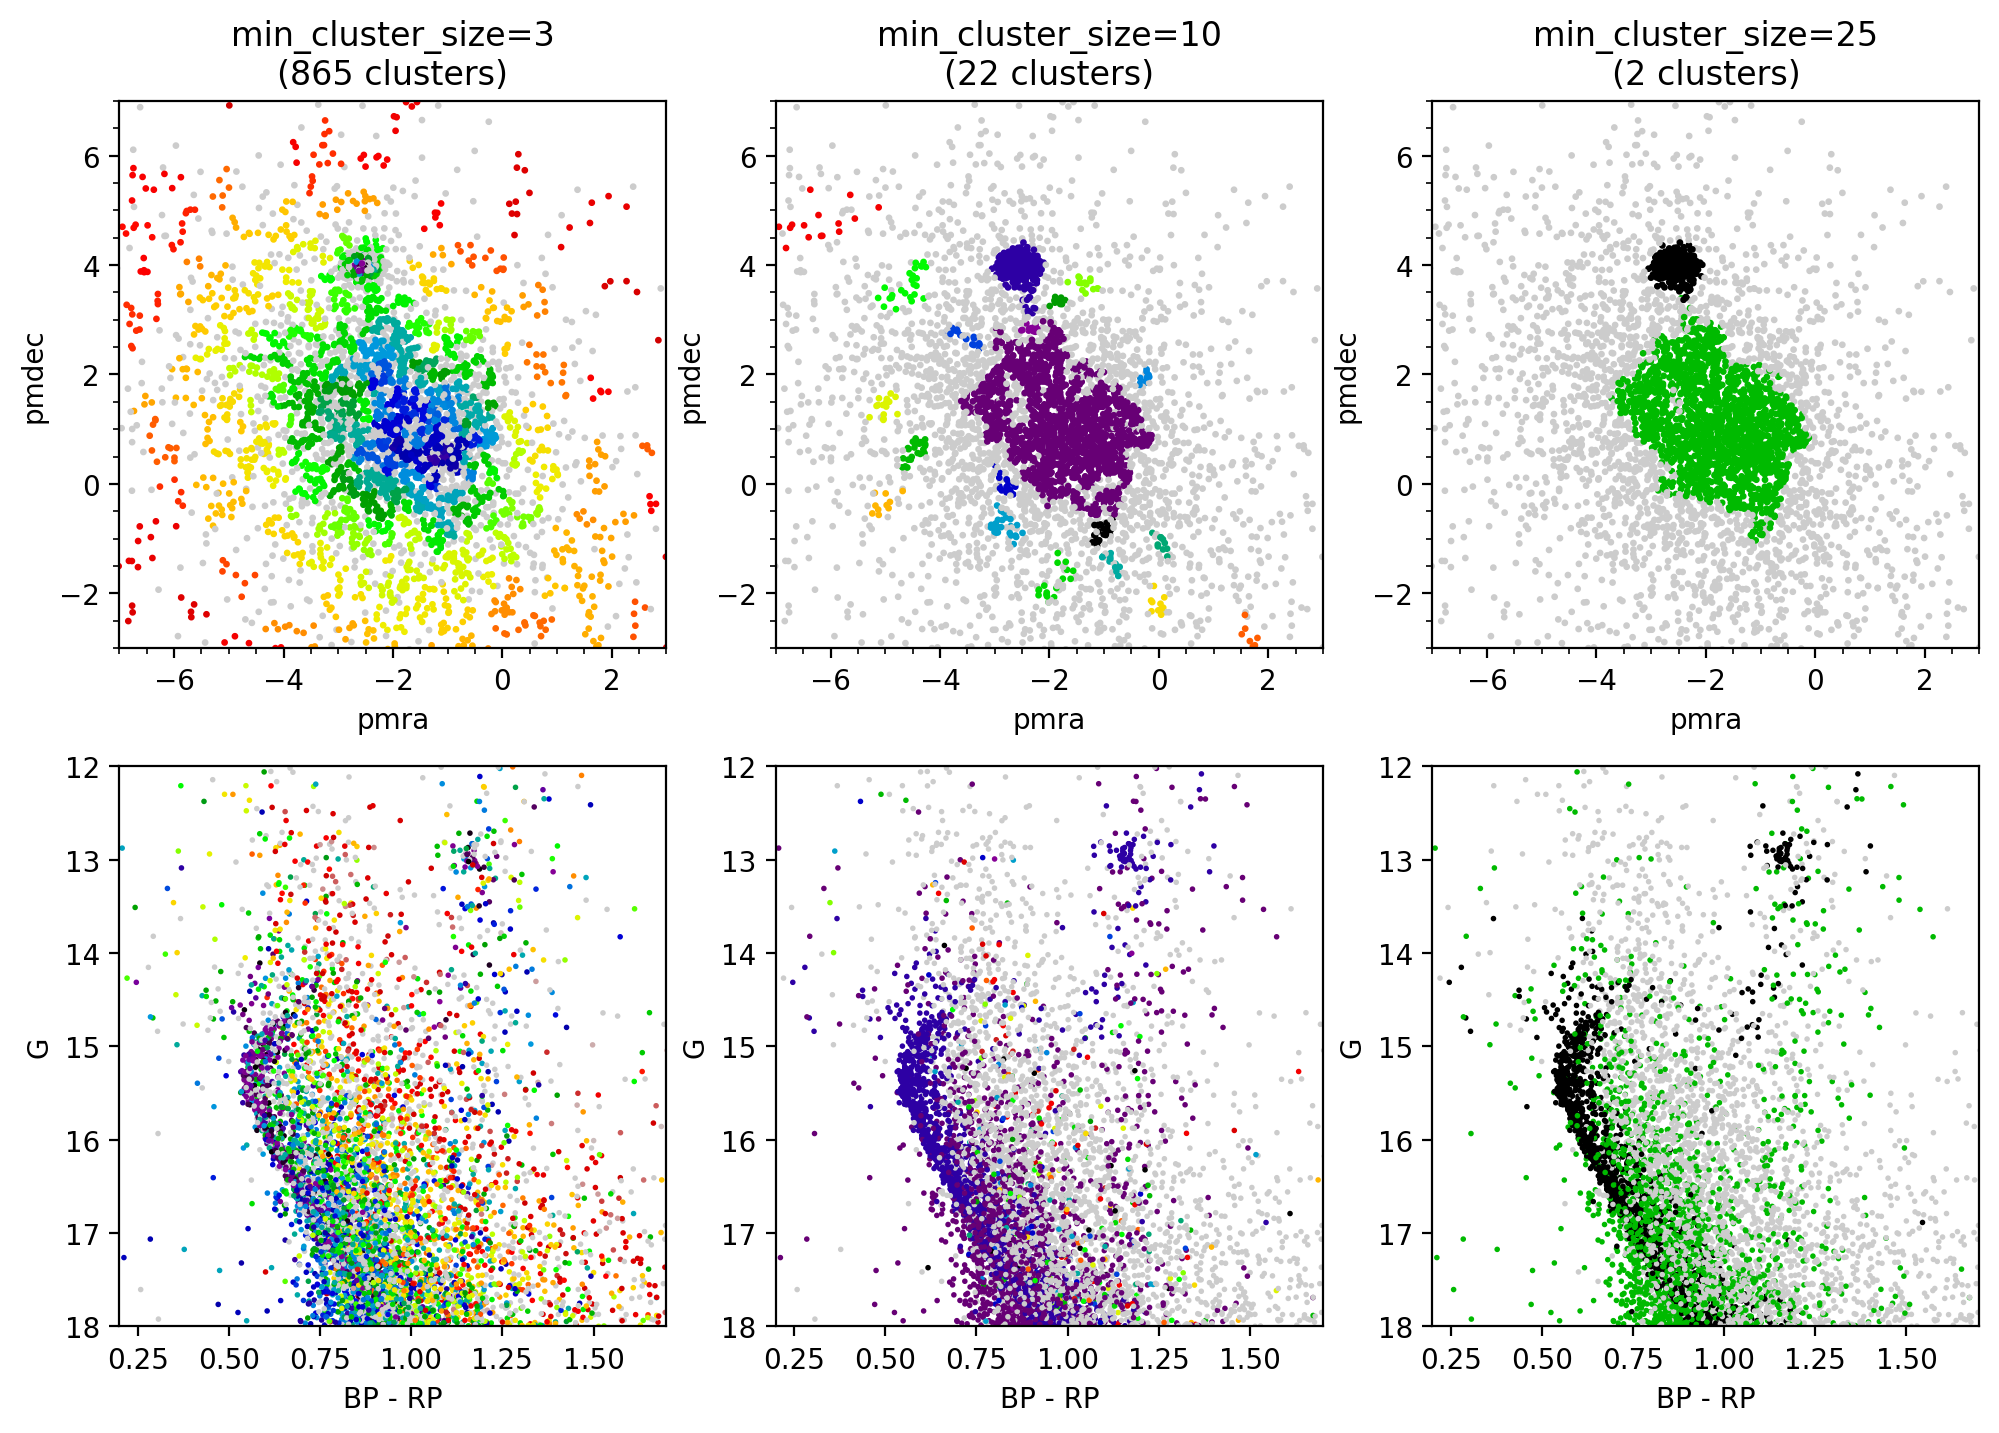

In [7]:
plt.figure(figsize=(12,8))
iii = 1

for min_cluster_size in [3,10,25]:

    hdb = HDBSCAN(min_cluster_size=min_cluster_size).fit(X)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(hdb.labels_)) - (1 if -1 in hdb.labels_ else 0)
    n_noise_ = list(hdb.labels_).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print('')

    # Plot the cluster labels in proper motion space:

    plt.subplot(2,3,iii,aspect=1)
    plt.title('min_cluster_size=%i\n(%i clusters)' % (min_cluster_size,n_clusters_))
    plt.minorticks_on()
    plt.scatter( GaiaT['pmra'] , GaiaT['pmdec'] , s=2 , c=hdb.labels_ , cmap='nipy_spectral_r')
    plt.xlim(-7,3); plt.ylim(-3,7)
    plt.xlabel('pmra'); plt.ylabel('pmdec')

    plt.subplot(2,3,iii+3)
    plt.scatter( GaiaT['bp_rp'] , GaiaT['phot_g_mean_mag'] , s=1 , c=hdb.labels_ , cmap='nipy_spectral_r' )
    plt.xlim(0.2,1.7); plt.ylim(18,12)
    plt.xlabel('BP - RP'); plt.ylabel('G')
    
    iii += 1

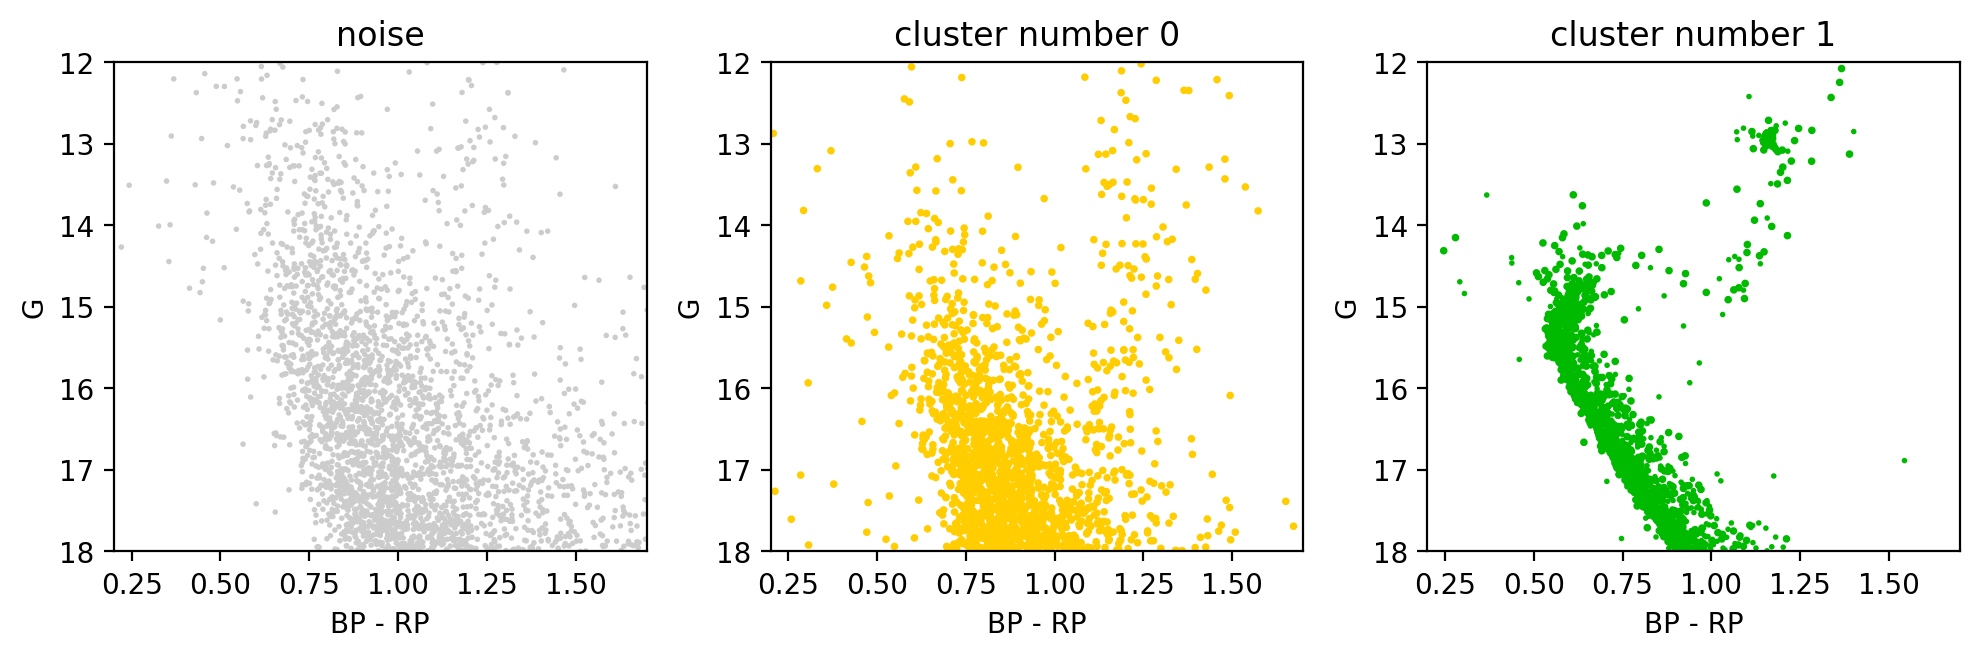

In [8]:
plt.figure(figsize=(10,6))
for iii,cId in enumerate(sorted(set(hdb.labels_))[:5]):

    proba = hdb.probabilities_[hdb.labels_==cId] # to display as marker size
    proba[proba>0.9] = 10
    proba[proba>0.7] = 3
    proba[proba<3] = 1
    
    plt.subplot(2,3,iii+1)
    if cId>-1:
        plt.title('cluster number %i' % (cId))
    else:
        plt.title('noise')        
    plt.scatter( GaiaT['bp_rp'][hdb.labels_==cId] , GaiaT['phot_g_mean_mag'][hdb.labels_==cId] ,
                s=proba , c=hdb.labels_[hdb.labels_==cId] , cmap='nipy_spectral_r',
               vmin=-1, vmax=3)
    plt.xlim(0.2,1.7); plt.ylim(18,12)
    plt.xlabel('BP - RP'); plt.ylabel('G')
    
plt.tight_layout()